# RCNN STUDY 

In this code I study the RCNN algorithm.
There are better algorithms like Fast-RCNN and YOLO, but this is relatively is simple of develop, than I choose it.
It is better than CNN because we not need to classify huge number of regions, we can use a limited number of regions.

Well I liked so much on study this, it worked good for airplane recognition and classifier.

Dataset link: https://drive.google.com/drive/folders/1aB8CDHgWSxeA4Gq5n0iBH718PDGzUi3k?usp=sharing

Refenres: https://towardsdatascience.com/step-by-step-r-cnn-implementation-from-scratch-in-python-e97101ccde55

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential, load_model

from tensorflow.keras import Model, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import cv2
import shutil

In [2]:
# SHOW IMAGE AND CREATE A RED RECTANGLE FOLLOWING THE DATASET COORDS
def showImages(img_path, csv_path, filename):
    csv_filename = filename.split('.')[0] + ".csv"

    image = cv2.imread(os.path.join(img_path, filename))
    df = pd.read_csv(os.path.join(csv_path, csv_filename))

    gtvalues = []
    plt.imshow(image)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})
        cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.figure()
    plt.imshow(image)
    

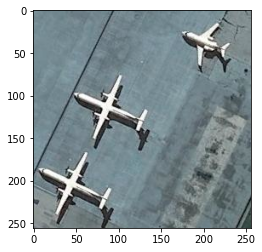

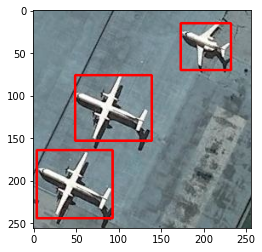

In [3]:
showImages("../dataset/Images", "../dataset/Airplanes_Annotations", "airplane_001.jpg")

In [4]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

# FUNCTION THAT CALCULATE THE IOU, THESE FUNCTION RETURN A VALUE NEAR TO 1 THE PREDICTED SQUARE IS ON THE DATASET
# SQUARE OR 1 IF IS EXACLY EQUAL TO THE DATASET SQUARE
def get_iou(bb1, bb2):
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left   = max(bb1['x1'], bb2['x1'])
    y_top    = max(bb1['y1'], bb2['y1'])
    x_right  = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou

In [29]:
# THESE METHOD USE OpenCV switchToSelectiveSearchFast TO SEARCH BY THE OBJECTS ON A SPECIFIC IMAGE
# THAN COMPARE WITH THE DATASET AIRPLANES POSITION COORDS AND SAVE ALL THE FOUNDED IMAGES WITH THE 
# SIZE OF 224x224 AND SAVE. SOME IMAGES THAT ARE NOT AIRPLANES ARE SAVED TO, BECAUSE THEY WILL BE USED HOW 
# not_airplane IMAGES FOR TRAINING
# A TOTAL OF 3000 IMAGES CAN BE GENERATED BY RAW IMAGE
# RETURN THE PATH IMAGES VECTOR AND THE COUNTERS FOR UPDATE
def imagePreProcessor(path, csv_path, filename, e, air_counter, not_air_counter, folder_path):
    
    train_images = []
    
    # GET FILE NAME
    csv_filename = filename.split('.')[0] + ".csv"
    print(f"{e} - File: {filename}")
    
    # OPEN IMAGE
    image = cv2.imread(os.path.join(path, filename))
    # CREATE A DATAFRAME WITH THE AIRPLANE IMAGES COORDS
    df = pd.read_csv(os.path.join(csv_path, csv_filename))

    gtvalues = []
    
    # FOR ALL COORDS APPEND TO A VECTOR
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})
    
    # USE OPENCV TO SEARCH FOR OBJECTS ON IMAGE
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()

    counter = 0
    false_counter = 0
    flag = 0
    fflag = 0
    bflag = 0
    
    # FOR EACH OBJECT FOUNDED
    for e, result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            # COMPARE WITH THE RIGHT AIRPLANE ON IMAGE
            for gtval in gtvalues:
                x, y, w, h = result

                iou = get_iou(gtval, {"x1":x, "x2":x+w, "y1":y, "y2":y+h})
                
                # GET A MAX OF 30 IMAGES
                if counter < 30:
                    # IF IS BIG THA 0.70 MEAN THAT THE IMAGE HAS A BIG SIMILARITY WITH THE DATASET COORDS
                    if iou > 0.70:
                        # GET THE PIECE OF FOUNDED IMAGE AND SAVE ON FOLDER WITH "airplane_"+counter NAME
                        # AND APPEND TO THE PATH IAMGES VECTOR
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage,  (224, 224), interpolation = cv2.INTER_AREA)
                        file_name = f"{folder_path}/airplane_{air_counter}.jpg"
                        cv2.imwrite(file_name, resized)
                        train_images.append(file_name)
                        air_counter += 1

                        counter += 1
                else:
                    fflag = 1
                if false_counter < 30:
                    # IF THE IOU RESULT IS LESS THAN 0.3 THE IMAGE HAS NOT SIMILARITY, BUT WE CAN USE IT WITH A EXAMPLE 
                    # OF A NOT AIRPLANE TO TRAIN.
                    if iou < 0.3:
                        # THEN SAVE THE IMAGE WITH THE "not_airplane_"+counter NAME
                        # AND SABE OUR PATH IN VECTOR IMAGES PATH
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                        file_name = f"{folder_path}/not_airplane_{not_air_counter}.jpg"
                        cv2.imwrite(file_name, resized)
                        train_images.append(file_name)
                        not_air_counter += 1
                        false_counter += 1
                else:
                    bflag = 1
            # FOUND THR TOTAL OF 30 IMAGES OF AIRPLANE AND NOT_AIRPLANE
            if fflag == 1 and bflag == 1:
                print("Get 30 of each.")
                flag = 1
                
    return (train_images, air_counter, not_air_counter)

In [31]:
# RUN THE IMAGE PREPROCESS ON ALL AIRPLANES IMAGES DATASET AND SAVE THE VECTOR OF IMAGES PATH 
def runImagePre(path, csv_path):
    main_path = os.getcwd().split("/code")[0]
    new_image_path = main_path + "/dataset/preImages"
    
    try:
        os.mkdir(new_image_path)
    except Exception as e:
        print(f"Error: {e}")
        
    
    images_list = []
    
    air_counter = 0
    not_air_counter = 0    
    
    for e, i in enumerate(os.listdir(path)):
        try:
            if i.startswith("airplane"):
                temp_images, air_counter, not_air_counter = imagePreProcessor(path, csv_path, i, e, air_counter, not_air_counter, new_image_path)
                images_list += temp_images
        except Exception as e:
            print(e)
            print("Error")
            continue
        
    return images_list



In [ ]:
# HERE WE CREATE THE FOLDER STRUCTURE FOR USE WITH THE flow_from_directory, I CHOOSE THIS METHOD FOR MEMORY USE SAVE
def createNewExtructureFolder(train_images, path):
    # CREATE train AND test Folder
    try:
        os.mkdir(new_image_path+"/train")
        os.mkdir(new_image_path+"/test")        
    except Exception as e:
        print(f"Message: {e}")
        
    # CREATE THE CLASSES FOLDERS ON train
    try:
        os.mkdir(new_image_path+"/train/airplane")
        os.mkdir(new_image_path+"/train/not_airplane")
    except Exception as e:
        print(f"Message: {e}")

    # CREATE THE CLASSES FOLDERS ON test
    try:
        os.mkdir(new_image_path+"/test/airplane")
        os.mkdir(new_image_path+"/test/not_airplane")
    except Exception as e:
        print(f"Message: {e}")
        
    # CREATE A DATA FRAME WITH THE PIECE IMAGES PATH VECTOR AND DIVIDE BETWEEN TRAIN AND TEST SAMPLES USING train_test_split
    df = pd.DataFrame(train_images)
    X_train, X_test = train_test_split(df, test_size=0.3)
    
    # NOW MOVE ALL FILES TO SPECIFIC FOLDER
    for idx, path in X_train.iterrows():
        if "not" in path[0].split("/")[-1]:
            shutil.move(path[0], new_image_path+"/train/not_airplane")
        else:
            shutil.move(path[0], new_image_path+"/train/airplane")
            
    for idx, path in X_test.iterrows():
        if "not" in path[0].split("/")[-1]:
            shutil.move(path[0], new_image_path+"/test/not_airplane")
        else:
            shutil.move(path[0], new_image_path+"/test/airplane")

In [53]:
path = "../dataset/Images"
csv_path = "../dataset/Airplanes_Annotations"

train_images = runImagePre(path, csv_path)

Error: [Errno 17] File exists: '/Users/ivastival/OneDrive/Developer/DataScience/RCNN/dataset/preImages'
0 airplane_079.jpg
1 airplane_045.jpg
inside
2 airplane_051.jpg
3 airplane_086.jpg
4 airplane_092.jpg
5 airplane_509.jpg
6 airplane_521.jpg
7 airplane_247.jpg
8 airplane_253.jpg
9 airplane_535.jpg
10 airplane_284.jpg
11 airplane_290.jpg
12 airplane_469.jpg
inside
13 airplane_455.jpg
14 airplane_333.jpg
15 airplane_327.jpg
16 airplane_441.jpg
18 airplane_496.jpg
19 airplane_482.jpg
20 airplane_119.jpg
inside
21 airplane_131.jpg
22 airplane_657.jpg
23 airplane_643.jpg
24 airplane_125.jpg
25 airplane_694.jpg
26 airplane_680.jpg
27 airplane_681.jpg
28 airplane_695.jpg
29 airplane_642.jpg
30 airplane_124.jpg
31 airplane_130.jpg
32 airplane_656.jpg
33 airplane_118.jpg
34 airplane_483.jpg
35 airplane_497.jpg
inside
37 airplane_326.jpg
inside
38 airplane_440.jpg
39 airplane_454.jpg
40 airplane_332.jpg
inside
41 airplane_468.jpg
42 airplane_291.jpg
inside
43 airplane_285.jpg
44 airplane_252.j

In [54]:
main_path = os.getcwd().split("/code")[0]
new_image_path = main_path + "/dataset/preImages"

createNewExtructureFolder(train_images, new_image_path)

In [67]:
# MAIN METHOD EXECUTION
# HERE WE CALL ALL THE PREVIOUS METHODS AND CREATE THE CNN MODEL TO TRAIN AND TEST
def run(train_images):

    # TO OPTIMIZATE THE MODEL I USE THE VGG16 PRE TRAINED MODEL
    # THIS MODEL REDUCE THE TIME AND INCREASE A ACCURACY QUICKLY
    vggmodel = VGG16(weights="imagenet", include_top = True)
    
    # MANTAIN THE FIRST 15 WIGHTS, SET IT WITH NOT TRAINABLE
    for layers in (vggmodel.layers)[:15]:
        layers.trainable = False

    # AND ON THE LAST 2 LAYERS, THE OUTPUT LAYERS, SET AS BINARY, IS AIPLANE OR NOT
    X = vggmodel.layers[-2].output
    predictions = Dense(2, activation="softmax")(X)
    model_final = Model(vggmodel.input, predictions)
    
    # CONFIGURE THE OPTMIZER, LOSS AND METRICS
    opt = Adam(learning_rate = 0.0001)
    model_final.compile(loss = keras.losses.categorical_crossentropy, optimizer = opt, metrics = ["accuracy"])
    model_final.summary()
    
    # USE ImageDataGenerator TO GENERATE MORE IMAGES AND TO LOAD IMAGES IN EXACT FORM TO PASS TO THE MODEL
    trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    traindata = trdata.flow_from_directory("../dataset/preImages/train", target_size=(224, 224))
    
    tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    testdata = tsdata.flow_from_directory("../dataset/preImages/test", target_size=(224, 224))
    
    # CREATE A CHECK POINT TO SAVE THE MODEL
    checkpoint = ModelCheckpoint("../models/ieeecnn_vgg16_1.h5", monitor="accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", period=1)
    
    # AND A STOP CONDITION
    early = EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="auto")
    
    # EXECUTE THE MODEL
    hist = model_final.fit(traindata, steps_per_epoch=10, epochs=100, validation_data=testdata, validation_steps=2, callbacks=[checkpoint, early])
    
    # FINALY SAVE THE MODEL
    model_final.save("../models/rcnn_test_model.h5")
    return model_final

In [68]:
model = run(train_images)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

KeyboardInterrupt: 

In [11]:
# PREDICT IMAGE
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def predictImage(path, filename, model):
    predicted = {}
    
    image = cv2.imread(os.path.join(path, filename))
    
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    
    for e, result in enumerate(ssresults):
        x,y,w,h = result;
        timage = imout[y:y+h, x:x+w]
        resized = cv2.resize(timage,  (224, 224), interpolation = cv2.INTER_AREA)
        img = np.expand_dims(resized, axis=0)
        prediction = model.predict(img)
#         print(prediction)
        if prediction[0][0] > 0.70:
            cv2.rectangle(imout, (x,y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure()
    plt.imshow(imout)
    plt.show()

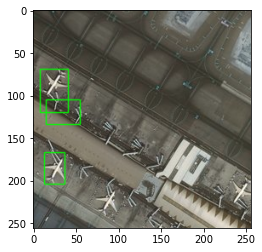

In [13]:
predictImage("../dataset/Images", "42845.jpg", model)